In [71]:
import streamlit as st

import geemap, ee
import geopandas as gpd
from shapely.geometry import Polygon

st.set_page_config(layout="wide")
@st.cache_data
def ee_authenticate(token_name="EARTHENGINE_TOKEN"):
    geemap.ee_initialize(token_name=token_name)

def getNDVI(image):    
    # Normalized difference vegetation index (NDVI)
    ndvi = image.normalizedDifference(['B8','B4']).rename("NDVI")
    image = image.addBands(ndvi)

    return(image)

def addDate(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return image.addBands(ee.Image(img_date).rename('date').toInt())


st.title("NDVI Map Canterbury Region")
ee_authenticate(token_name="EARTHENGINE_TOKEN")

aoi = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM1_NAME','Bijoutier')).geometry()

NDVI_data = ee.ImageCollection('COPERNICUS/S2_SR').filterDate("2023-01-01","2023-01-31").filterBounds(aoi) \
    .map(getNDVI).map(addDate).median()

color = ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
               '74A901', '66A000', '529400', '3E8601', '207401', '056201',
               '004C00', '023B01', '012E01', '011D01', '011301']
pallete = {"min":0, "max":1, 'palette':color}
# initialize our map
map1 = geemap.Map()
map1.centerObject(aoi)
map1.addLayer(NDVI_data.clip(aoi).select('NDVI'), pallete, "NDVI-Canterbury")

map1.addLayerControl()
map1

# map1.to_streamlit(height=700)


2023-05-30 16:01:37.302 No runtime found, using MemoryCacheStorageManager


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [72]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
dates = []
ndvi_values = []

collection = ee.ImageCollection('COPERNICUS/S2_SR').filterDate("2023-01-01","2023-01-10").filterBounds(aoi) \
    .map(getNDVI)

image_ids = collection.aggregate_array('system:index').getInfo()
image_ids

['20230102T065019_20230102T065050_T39MXN',
 '20230107T065021_20230107T065028_T39MXN']

In [101]:
image_id = '20230102T065019_20230102T065050_T39MXN'
image = collection.filter(ee.Filter.eq('system:index', image_id)).first()   
image
date = image.date().format('yyyy-MM-dd')
date.getInfo()
# ndvi_value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi, scale=10).get('NDVI').getInfo()
# ndvi_value

'2023-01-02'

In [100]:
type(date)

ee.ee_string.String

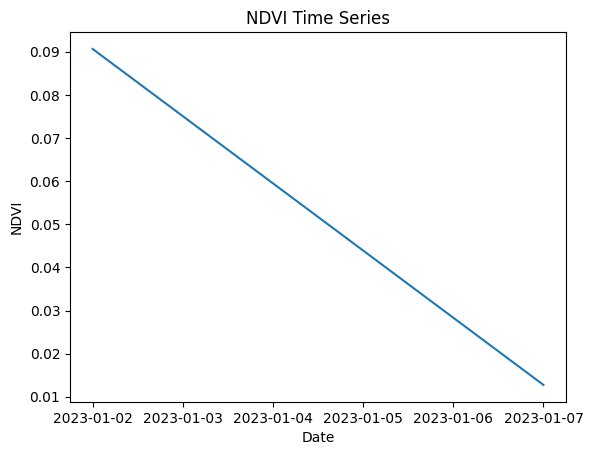

In [105]:
# Create a list to store the dates and NDVI values
dates = []
ndvi_values = []

# Iterate over the image IDs
for image_id in image_ids:
    # Get the image by ID
    image = collection.filter(ee.Filter.eq('system:index', image_id)).first()   
    
    # Get the image date and NDVI value
    date = image.date().format('yyyy-MM-dd')
    # print(date)
    ndvi_value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=aoi, scale=10).get('NDVI').getInfo()
    
    # Add the date and NDVI value to the lists
    dates.append(date.getInfo())
    ndvi_values.append(ndvi_value)

# # Create a pandas DataFrame from the lists
df = pd.DataFrame({'Date': dates, 'NDVI': ndvi_values})

# # Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by date
df.sort_values(by='Date', inplace=True)

# Plot the NDVI values through the time series
plt.plot(df['Date'], df['NDVI'])
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Time Series')
plt.show()

In [104]:
df

,Date,NDVI
0,2023-01-02,0.090664
1,2023-01-07,0.012746


In [ ]:
ee_authenticate(token_name="EARTHENGINE_TOKEN")

aoi = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM1_NAME','Canterbury')).geometry()

coordcan = aoi.coordinates().getInfo()
# polygons = [Polygon(polygon_coords) for polygon_coords in coordcan]

In [41]:
import ee
import geemap
import pandas as pd

# Initialize the Earth Engine API
ee.Initialize()

# Define the region of interest (ROI)
roi = ee.Geometry.Point(-122.084, 37.42)  # Example ROI coordinates

# Load an image collection
collection = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(roi) \
    .limit(10)

# Convert image collection to pandas DataFrame
df = geemap.ee_to_pandas(collection, properties=['system:index', 'system:time_start'])

# Print the DataFrame
print(df)


TypeError: ee_object must be an ee.FeatureCollection

In [12]:
roi_start_time, roi_end_time

(datetime.time(14, 0), datetime.time(1, 0))

In [23]:
from dateutil.rrule import rrule, MONTHLY
from datetime import datetime

start_date = datetime.strptime("2022-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2023-12-31", "%Y-%m-%d")

months = [dt.strftime("%m-%Y") for dt in rrule(MONTHLY, dtstart=start_date, until=end_date)]
print(months)


['01-2022', '02-2022', '03-2022', '04-2022', '05-2022', '06-2022', '07-2022', '08-2022', '09-2022', '10-2022', '11-2022', '12-2022', '01-2023', '02-2023', '03-2023', '04-2023', '05-2023', '06-2023', '07-2023', '08-2023', '09-2023', '10-2023', '11-2023', '12-2023']


In [ ]:
import streamlit as st
import datetime as dt
import pandas as pd
from dateutil.relativedelta import relativedelta # to add days or years


## Range selector
cols1,_ = st.beta_columns((1,2)) # To make it narrower
format = 'MMM DD, YYYY'  # format output
start_date = dt.date(year=2021,month=1,day=1)-relativedelta(years=2)  #  I need some range in the past
end_date = dt.datetime.now().date()-relativedelta(years=2)
max_days = end_date-start_date

slider = cols1.slider('Select date', min_value=start_date, value=end_date ,max_value=end_date, format=format)
## Sanity check
st.table(pd.DataFrame([[start_date, slider, end_date]],
                columns=['start',
                        'selected',
                        'end'],
                index=['date']))

In [28]:
from datetime import datetime, timedelta
import calendar

# Given month string
month_str = "01-2023"

# Convert month string to datetime object
month_date = datetime.strptime(month_str, "%m-%Y")

# Extract year and month from the datetime object
year = month_date.year
month = month_date.month

# Create start_date and end_date based on the given month
start_date = datetime(year, month, 1).strftime("%Y-%m-%d")
last_day = calendar.monthrange(year, month)[1]
# Create the end date for the month
end_date = datetime(year, month, last_day).strftime("%Y-%m-%d")

# Print the start_date and end_date
print("start_date:", start_date)
print("end_date:", end_date)


start_date: 2023-01-01
end_date: 2023-01-31


In [26]:
import calendar
from datetime import datetime, timedelta

# Given year
year = 2023

# Iterate over each month of the year
for month in range(1, 13):
    # Get the last day of the month
    last_day = calendar.monthrange(year, month)[1]

    # Create the end date for the month
    end_date = datetime(year, month, last_day).strftime("%Y-%m-%d")

    # Print the end date
    print(f"End date of {calendar.month_name[month]}: {end_date}")


End date of January: 2023-01-31
End date of February: 2023-02-28
End date of March: 2023-03-31
End date of April: 2023-04-30
End date of May: 2023-05-31
End date of June: 2023-06-30
End date of July: 2023-07-31
End date of August: 2023-08-31
End date of September: 2023-09-30
End date of October: 2023-10-31
End date of November: 2023-11-30
End date of December: 2023-12-31


In [34]:
filteredCollection = collection.select('ndvi') \
  .filter(ee.Filter.bounds(testPoint.geometry()))

def func_xvr(image):
  stats = image.reduceRegion({
    'reducer': ee.Reducer.mean(),
    'geometry': testPoint.geometry(),
    'scale': 10,
    'maxPixels': 1e10
  })
  # reduceRegion doesn't return any output if the image doesn't intersect
  # with the point or if the image is masked out due to cloud
  # If there was no ndvi value found, we set the ndvi to a NoData value -9999
  ndvi = ee.List([stats.get('ndvi'), -9999]) \
    .reduce(ee.Reducer.firstNonNull())

  # Create a feature with None geometry and NDVI value and date as properties
  f = ee.Feature(None, {'ndvi': ndvi,
    'date': ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')})
  return f

timeSeries = ee.FeatureCollection(filteredCollection.map(func_xvr
))

))

# Check the results
print(timeSeries.first())

# # Export to CSV
# Export.table.toDrive({
#     'collection': timeSeries,
#     'description': 'Single_Location_NDVI_time_series',
#     'folder': 'earthengine',
#     'fileNamePrefix': 'ndvi_time_series_single',
#     'fileFormat': 'CSV'
# })


TypeError: ee_object must be an ee.FeatureCollection

In [35]:
import geemap

map = geemap.Map()
map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
#Import GEE Feature Collection (Somaliland kml)
geometry = ee.FeatureCollection('ft:1bzF2pepsJHoGIXn-ojYYOkOBHWtfhqzS9QLuz_l3')

# Create image collection of S-2 imagery for the perdiod 2016-2018
S2 = ee.ImageCollection('COPERNICUS/S2') \
.filterDate('2018-09-01', '2018-10-31') \
.filterBounds(geometry)

# Function to mask cloud from built-in quality band
# information on cloud
def maskcloud1(image):
    QA60 = image.select(['QA60'])
    return image.updateMask(QA60.lt(1))

# Function to calculate and add an NDVI band
def addNDVI(image):
    return image.addBands(image.normalizedDifference(['B8', 'B4']))

# Add NDVI band to image collection
S2 = S2.map(addNDVI)
# Extract NDVI band and create NDVI median composite image
NDVI = S2.select(['nd'])
NDVImed = NDVI.median(); #I just changed the name of this variable ;)

# Create palettes for display of NDVI
ndvi_pal = ['#d73027', '#f46d43', '#fdae61', '#fee08b', '#d9ef8b',
'#a6d96a']

# Create a time series chart.
# plotNDVI = ui.Chart.image.seriesByRegion(S2, geometry,ee.Reducer.mean(),
# 'nd',500,'system:time_start', 'system:index') \
#               .setChartType('LineChart').setOptions({
#                 'title': 'NDVI short-term time series',
#                 'hAxis': '{title': 'Date'},
#                 'vAxis': '{title': 'NDVI'}
# })

# Display.
# print(plotNDVI)

# Display NDVI results on map
# map1.addLayer(NDVImed.clip(geometry), {'min':-0.5, 'max':0.9, 'palette': ndvi_pal}, 'NDVI')
# map1

In [63]:
NDVImed